In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean
from pyqg_generative.tools.plot_helpers import *
from pyqg_generative.tools.computational_tools import PDF_histogram
from pyqg_generative.tools.operators import Operator1, Operator2, PV_subgrid_forcing, ave_lev, coord
%load_ext autoreload
%autoreload 3

import hvplot.xarray
import holoviews as hv
hvplot.output(widget_location='bottom')

import warnings
warnings.filterwarnings("ignore")

In [2]:
def reader(path):
    ds = xr.open_dataset(path)
#    return ds
    time = slice(44,None)    
    ds = ds.drop_vars(('PDF0', 'PDF1', 'PDF_gen0', 'PDF_gen1', 'PDF_mean0', 'PDF_mean1', 
                       'PDF_res0', 'PDF_res1', 'PDF_gen_res0', 'PDF_gen_res1', 'q_0', 'q_1'))
    
    time = slice(44,None)
    Nbins = 70
    target = 'q_forcing_advection'
    for lev in [0,1]:
        arr = ds[target].isel(time=time, lev=lev)
        mean, std = arr.mean(), arr.std()
        xmin = -5; xmax = 5
        coords = None
        for suffix in ['', '_gen', '_mean']:
            array = ds[target+suffix].isel(time=time, lev=lev).values.ravel() / float(std)
            points, density = PDF_histogram(array, xmin = xmin, xmax=xmax, Nbins=Nbins)
            if coords is None:
                coords=[coord(points, 'RMS units')]
                
            ds['PDF'+suffix+str(lev)] = xr.DataArray(density, dims='q_'+str(lev), coords=coords)
    
    for lev in [0,1]:
        arr = ds[target+'_res'].isel(time=time, lev=lev)
        mean, std = arr.mean(), arr.std()
        xmin = -5; xmax = 5
        coords = None
        for suffix in ['_res', '_gen_res']:
            array = ds[target+suffix].isel(time=time, lev=lev).values.ravel() / float(std)
            points, density = PDF_histogram(array, xmin = xmin, xmax=xmax, Nbins=Nbins)
            if coords is None:
                coords=[coord(points, 'RMS units')]
            ds['PDF'+suffix+str(lev)] = xr.DataArray(density, dims='dq_'+str(lev), coords=coords)
    
    return ds

# Prediction of stochastic residuals with shallow CNN

In [27]:
gz = reader(
    '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/MeanVarModel-0/offline_test.nc')

gz_jet = reader(
    '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/MeanVarModel-0/offline_transfer.nc')

In [5]:
gan = reader(
    '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-0/offline_test.nc')


gan_jet = reader(
    '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-0/offline_transfer.nc')

In [6]:
vae = reader(
    '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CVAERegression-None-0/offline_test.nc')

vae_jet = reader(
    '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CVAERegression-None-0/offline_transfer.nc')

In [31]:
std = gz.q_forcing_advection.isel(lev=0,time=slice(44,None)).std()

(0.0, 150000000000.0)

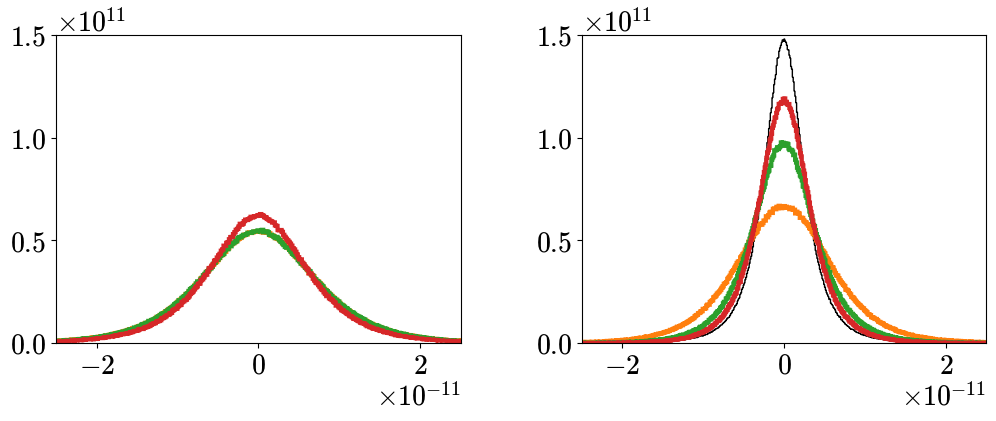

In [76]:
default_rcParams({'lines.linewidth': 10, 'font.size':20})
nbins=1000
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(gz.q_forcing_advection.isel(lev=0,time=slice(44,None)).values.ravel(),nbins, density=True,histtype='step',color='k',lw=1);
plt.hist(gz.q_forcing_advection_gen.isel(lev=0,time=slice(44,None)).values.ravel(),nbins, density=True,histtype='step',color='tab:orange',lw=3);
plt.hist(gan.q_forcing_advection_gen.isel(lev=0,time=slice(44,None)).values.ravel(),nbins, density=True,histtype='step',color='tab:green',lw=3);
plt.hist(vae.q_forcing_advection_gen.isel(lev=0,time=slice(44,None)).values.ravel(),nbins, density=True,histtype='step',color='tab:red',lw=3);
plt.xlim([-0.25e-10,0.25e-10])
plt.ylim([0, 1.5e+11])
plt.subplot(1,2,2)
plt.hist(gz_jet.q_forcing_advection.isel(lev=0,time=slice(44,None)).values.ravel(),nbins, density=True,histtype='step',color='k', lw=1);
plt.hist(gz_jet.q_forcing_advection_gen.isel(lev=0,time=slice(44,None)).values.ravel(),nbins, density=True,histtype='step',color='tab:orange', lw=3);
plt.hist(gan_jet.q_forcing_advection_gen.isel(lev=0,time=slice(44,None)).values.ravel(),nbins, density=True,histtype='step',color='tab:green', lw=3);
plt.hist(vae_jet.q_forcing_advection_gen.isel(lev=0,time=slice(44,None)).values.ravel(),nbins, density=True,histtype='step',color='tab:red', lw=3);
plt.xlim([-0.25e-10,0.25e-10])
plt.ylim([0, 1.5e+11])
#plt.yscale('log')

In [3]:
def plot_spectra(operator='Operator1', resolution=48, lev=0, gan_folder='CGANRegression-retrain', vae_folder='CVAERegression-None', gz_model='0', gan_model='0', vae_model='0', ds=False, file='offline_test.nc', models_folder='models_retrain'):
    default_rcParams({
    'lines.linewidth': 1.5,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titlesize': 14,
    'lines.markersize': 2
})
    cl = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    lss = ['-', '-', '-', '-']
    mks = ['d', 'o', None, None]

    mse = reader(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/{models_folder}/'+operator+'-'+str(resolution)+f'/OLSModel-{gz_model}/{file}').isel(lev=lev)
    gz = reader(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/{models_folder}/'+operator+'-'+str(resolution)+f'/MeanVarModel-{gz_model}/{file}').isel(lev=lev)
    gan = reader(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/{models_folder}/'+operator+'-'+str(resolution)+f'/{gan_folder}-{gan_model}/{file}').isel(lev=lev)
    vae = reader(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/{models_folder}/'+operator+'-'+str(resolution)+f'/{vae_folder}-{vae_model}/{file}').isel(lev=lev)
    
    if ds:
        return mse, gz, gan, vae

    fig, axs = plt.subplots(2,2, figsize=(10,5))
    plt.subplots_adjust(wspace=0.3, hspace=0.35)

    ax = axs[1][0]
    mse.Eflux.plot(ax=ax, color='k', ls='--', lw=3, label='True')
    for m, color, ls, mk, label in zip([mse, gz, gan, vae], cl, lss, mks, ['MSE', 'GZ', 'GAN', 'VAE']):
        m.Eflux_gen.plot(ax=ax, color=color, label=label, ls=ls, marker=mk)
    ax.set_title('')
    ax.set_ylabel('Energy transfer \n by subgrid forcing, $m^3/s^3$')

    ax = axs[0][1]
    mse.PSD.plot(ax=ax, color='k', ls='--', lw=3, label='True')
    for m, color, ls, mk, label in zip([mse, gz, gan, vae], cl, lss, mks, ['MSE', 'GZ', 'GAN', 'VAE']):
        m.PSD_gen.plot(ax=ax, color=color, ls=ls, label=label, marker=mk)
    ax.set_title('')
    ax.set_ylabel('Power spectrum of \n subgrid forcing, $sp(S), m/s^4$')
    ax.legend(fontsize=11, frameon=False)


    ax = axs[0][0]
    gan.PSD_res.plot(ax=ax, ls='--', color='k', lw=3)
#    gz.PSD_res.plot(ax=ax, ls='--', color='gray', lw=3)
    gz.PSD_gen_res.plot(ax=ax, color=cl[1], ls=lss[1], marker=mks[1])
    gan.PSD_gen_res.plot(ax=ax, color=cl[2], ls=lss[2], marker=mks[2])
    vae.PSD_gen_res.plot(ax=ax, color=cl[3], ls=lss[3], marker=mks[3])
    ax.set_title('')
    ax.set_ylabel('Power spectrum of \n residuals, $sp(r), m/s^4$')

    ax = axs[1][1]
    if lev==0:
        key_ref = 'PDF0'
        key = 'PDF_gen0'
    else:
        key_ref = 'PDF1'
        key = 'PDF_gen1'
    
    mse[key_ref].plot(ax=ax, color='k', ls='--', lw=3)
    for m, color, ls, mk in zip([mse, gz, gan, vae], cl, lss, mks):
        m[key].plot(ax=ax, color=color, ls=ls, marker=mk)
    ax.set_title('')
    ax.set_ylabel('PDF density of \n subgrid forcing $S$')
    ax.set_xlabel('RMS units')
    ax.set_yscale('log')

    for inset, xlim, ylim in zip(
        [[0.7, 0.55, 0.4, 0.5], [0.7, -0.05, 0.4, 0.5]],
        [[-1, 1], [-3, -2]],
        [[0.3, 0.7], [5e-3,5e-2]]
        ):
        ax_inset = ax.inset_axes(inset)
        mse[key_ref].plot(ax=ax_inset, color='k', ls='-', lw=3)
        for m, color, ls, mk in zip([mse, gz, gan, vae], cl, lss, mks):
            m[key].plot(ax=ax_inset, color=color, ls=ls, marker=mk)
        ax_inset.set_xlabel('')
        ax_inset.set_ylabel('')
        ax_inset.set_xticklabels([])
        ax_inset.set_yticklabels([])
        ax_inset.set_title('')
        ax_inset.set_xlim(xlim)
        ax_inset.set_ylim(ylim)
        ax.indicate_inset_zoom(ax_inset, edgecolor="black")
        
    dx = gan.x[2] - gan.x[1]
    for i in [0,1]:
        for j in [0,1]:
            if i==1 and j==1:
                break
            axs[i][j].axvline(x=np.pi/dx, ls='--', color='gray', lw=1)
            if operator == 'Operator1':
                axs[i][j].axvline(x=0.65*np.pi/dx, ls='-.', color='gray', lw=1)
    if lev==0:
        if operator == 'Operator2':
            axs[1][0].text(np.pi/dx, 2e-6, r'$\frac{\pi}{\Delta x}$', fontsize=14, color='gray')
        else:
            axs[1][0].text(np.pi/dx, 2e-6, r'$\frac{\pi}{\Delta x}$', fontsize=12, color='gray')
            axs[1][0].text(0.65*np.pi/dx, 2e-6, r'$0.65\frac{\pi}{\Delta x}$', fontsize=12, color='gray')

    for j in [0,1]:
        xlim = list(axs[0][0].get_xlim())
        xlim[0] = -0.1e-4
        if resolution == 48:
            xticks = [0, 0.00005, 0.0001, 0.00015, 0.0002]
        else:
            xticks = [0, 0.0001, 0.0002, 0.0003, 0.0004]
        axs[0][j].set_xticks(xticks)
        axs[0][j].set_xlim(xlim)
        axs[0][j].set_xlabel('wavenumber $\kappa, m^{-1}$')
        axs[1][0].set_xticks(xticks)
        axs[1][0].set_xlim(xlim)
        axs[1][0].set_xlabel('wavenumber $\kappa, m^{-1}$')
    
        
    fig.align_ylabels(axs[:,0])
    fig.align_ylabels(axs[:,1])
    
    set_letters(x=-0.07)
    return axs

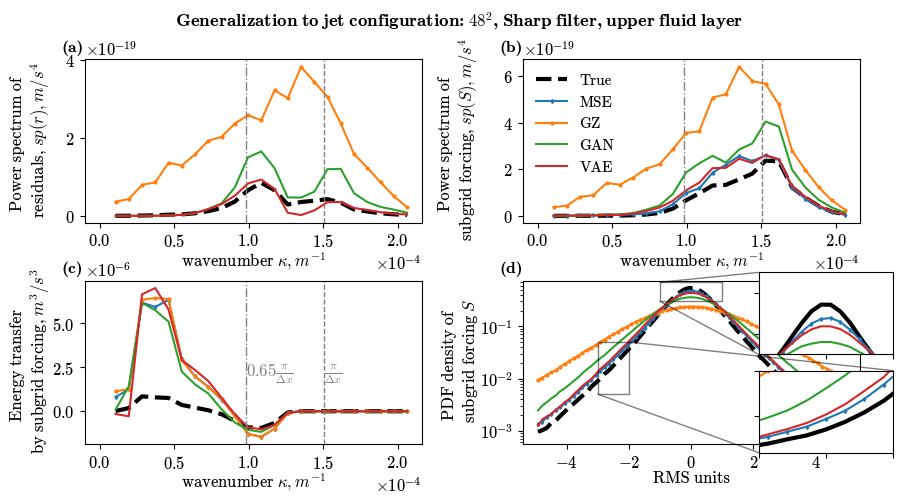

In [8]:
plot_spectra(file='offline_transfer.nc', gz_model='1')
plt.suptitle('Generalization to jet configuration: $48^2$, Sharp filter, upper fluid layer', fontweight='bold')
plt.savefig('review_figures/generalization_explain_48.pdf')

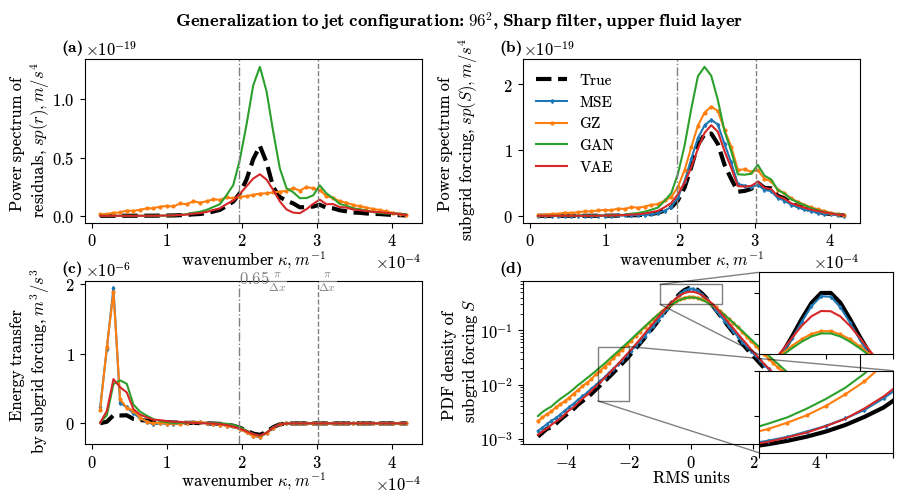

In [6]:
plot_spectra(resolution=96, file='offline_transfer.nc', gz_model='0')
plt.suptitle('Generalization to jet configuration: $96^2$, Sharp filter, upper fluid layer', fontweight='bold')
plt.show()
#plt.savefig('review_figures/generalization_explain.pdf')

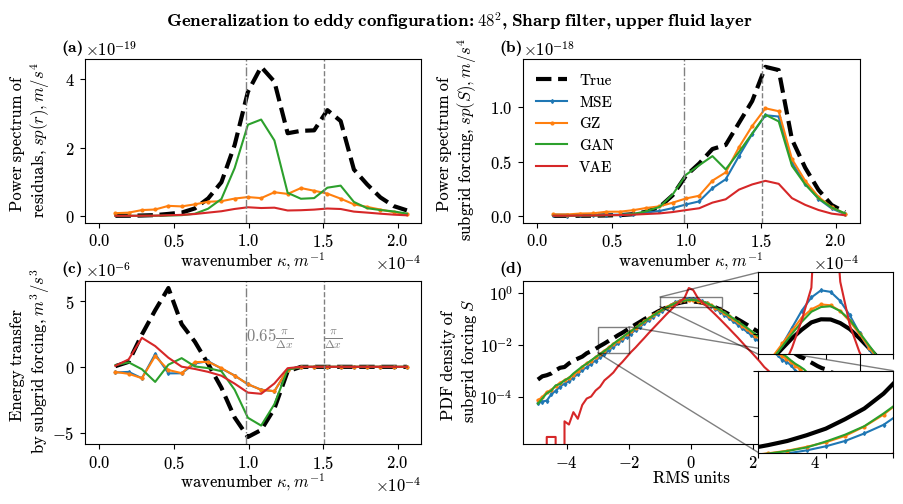

In [160]:
plot_spectra(gan_model='1',models_folder='models_jet', file='offline_transfer.nc', gan_folder='CGANRegression', vae_folder='CVAERegression')
plt.suptitle('Generalization to eddy configuration: $48^2$, Sharp filter, upper fluid layer', fontweight='bold')
plt.show()

In [119]:
gan = xr.open_dataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_jet/Operator1-48/CGANRegression-0/offline_transfer.nc')
gz = xr.open_dataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_jet/Operator1-48/MeanVarModel-0/offline_transfer.nc')

In [121]:
gan.L2_residual.values

array(0.75762314, dtype=float32)

In [122]:
gz.L2_residual.values

array(0.86280346, dtype=float32)

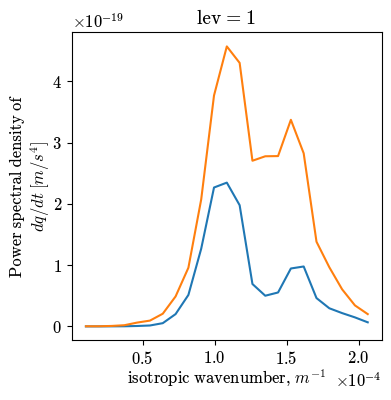

In [128]:
gan.PSD_gen_res.isel(lev=0).plot()
gan.PSD_res.isel(lev=0).plot()
plt.show()

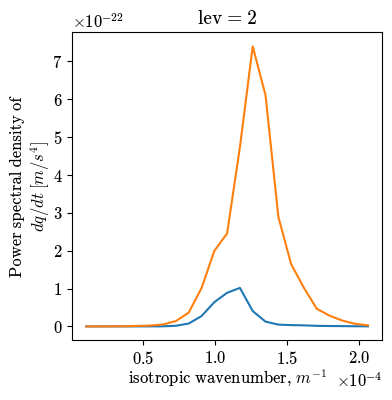

In [142]:
gan.PSD_gen_res.isel(lev=1).plot()
gan.PSD_res.isel(lev=1).plot()
plt.show()

In [137]:
def L2(pred,target):
    return float(np.sqrt(((pred-target)**2).mean()) / np.sqrt((target**2).mean()))

In [139]:
print(L2(gz.PSD_gen_res.isel(lev=0),gz.PSD_res.isel(lev=0)))
print(L2(gz.PSD_gen_res.isel(lev=1),gz.PSD_res.isel(lev=1)))

0.7779860496520996
0.9543135166168213


In [141]:
print(L2(gan.PSD_gen_res.isel(lev=0),gan.PSD_res.isel(lev=0)))
print(L2(gan.PSD_gen_res.isel(lev=1),gan.PSD_res.isel(lev=1)))

0.6070194244384766
0.9149913787841797


In [143]:
(0.6070194244384766+0.9149913787841797)/2

0.7610054016113281

In [144]:
(0.7779860496520996+0.9543135166168213)/2

0.8661497831344604

In [165]:
eddy = xr.open_dataset(
    f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/OLSModel-0/offline_test.nc')

jet = xr.open_dataset(
    f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/OLSModel-0/offline_transfer.nc')

In [167]:
eddy.q_forcing_advection.std(['run', 'time', 'x', 'y']).values

array([7.6333323e-12, 1.6686353e-13], dtype=float32)

In [168]:
jet.q_forcing_advection.std(['run', 'time', 'x', 'y']).values

array([2.8847905e-12, 2.6776051e-14], dtype=float32)

# Metrics for models trained on jet dataset and tested on eddy dataset

In [5]:
def read_metric(metric='L2_mean', model='OLSModel', model_num=0, resolution=64, operator='Operator1', exp='offline_test.nc', folder='models_jet'):
    file = os.path.join('/scratch/pp2681/pyqg_generative/Reference-Default-scaled', folder, operator+'-'+str(resolution),model+'-'+str(model_num),exp)
    if os.path.exists(file):
        # outlier
        if model in ['MeanVarModel', 'OLSModel'] and model_num==0:
            return np.nan
        else:
            ds = xr.open_dataset(file)
            return float(ds[metric].mean())
    else:
        print('Wrong path', file)

In [6]:
def read_line(**kw):
    res = [48, 64, 96]
    y = np.array([[read_metric(model_num=j, resolution=r, **kw) for j in range(2)] for r in res])
    res = xr.DataArray(res)
    trial = xr.DataArray(np.arange(2))
    y = xr.DataArray(y, dims=['res', 'trial'], coords=[res, trial])
    outlier = y * np.nan
    
    q25 = y.quantile(0.25, dim='trial', skipna=True).drop_vars('quantile')
    q50 = y.quantile(0.5, dim='trial', skipna=True).drop_vars('quantile')
    q75 = y.quantile(0.75, dim='trial', skipna=True).drop_vars('quantile')
    q0 = y.min(dim='trial', skipna=True)
    q100 = y.max(dim='trial', skipna=True)
    return xr.Dataset({'data': y, 'outlier': outlier, 'q25': q25, 'q50': q50, 'q75': q75, 'q0': q0, 'q100': q100})

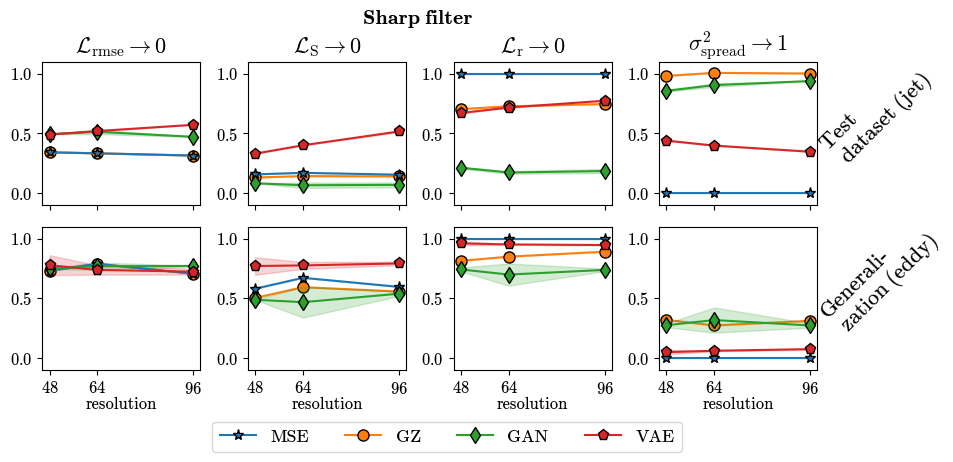

In [12]:
default_rcParams({
    'axes.formatter.limits': (-2,2),
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.labelsize': 12,
    'axes.titlelocation' : 'center',
    'lines.markersize': 8})
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
markers = ['*', 'o', 'd', 'p']
fig, axs = plt.subplots(2,4,figsize=(10,4))
plt.subplots_adjust(hspace=0.15, wspace=0.3)
operator = 'Operator1'
for i, exp in enumerate(['offline_test.nc', 'offline_transfer.nc']):
    for j, (model, label, marker, zorder) in enumerate(zip(['OLSModel', 'MeanVarModel', 'CGANRegression', 'CVAERegression'], ['MSE', 'GZ', 'GAN', 'VAE'], markers, [2,1,3,4])):
        res = [48, 64, 96]
        for col, metric in enumerate(['L2_mean', 'L2_total', 'L2_residual', 'var_ratio']):
            try:
                ds= read_line(metric=metric, model=model, operator=operator, exp=exp)
                ax = axs[i][col]
                ax.set_ylim([-0.1,1.1])
                #if metric != 'L2_mean' or label != 'MSE':                
                ax.plot(res, ds.q50, color=colors[j], label=label, marker=marker, zorder=zorder, markeredgecolor='k')
                ax.fill_between(res, ds.q0, ds.q100, color=colors[j], alpha=0.2)
            except:
                pass
            
for j in range(4):
    axs[1][j].set_xlabel('resolution')
    axs[0][j].set_xticks([48, 64, 96])
    axs[1][j].set_xticks([48, 64, 96])
    axs[0][j].set_xticklabels([])
    
#axs[0][0].set_ylim([0.0, 1.5])
#axs[0][1].set_ylim([0, 0.3])
#axs[0][2].set_ylim([-0.05, 1.1])
#axs[0][3].set_ylim([-0.05, 1.1])

for j in range(4):
    if j > 0:
        #axs[1][j].set_ylim([1e-1, 2e+1])
        #axs[1][j].set_yscale('log')
        pass
    else:
        pass
        #axs[1][j].set_ylim([0.0, 1.5])
    
axs[0][0].set_title(r'$\mathcal{L}_{\mathrm{rmse}} \rightarrow 0$')
axs[0][1].set_title(r'$\mathcal{L}_{\mathrm{S}} \rightarrow 0$')
axs[0][2].set_title(r'$\mathcal{L}_{\mathrm{r}} \rightarrow 0$')
axs[0][3].set_title(r'$\sigma^2_{\mathrm{spread}} \rightarrow 1$')

axs[1][2].legend(bbox_to_anchor=(1.5,-0.3), ncol=4, fontsize=13)

fig.text(0.9, 0.62, 'Test \n dataset (jet)', fontsize=16, rotation=45)
fig.text(0.9, 0.2, 'Generali-\n zation (eddy)', fontsize=16, rotation=45)
plt.suptitle('Sharp filter', y=1.01, fontweight='bold', fontsize=14)

#plt.show()
plt.savefig('review_figures/generalization_eddy.pdf')